## Determination of Three Regimes and Creation of Regime Labels with ML Techniques

In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import os
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
import math

import logging.config
logging.config.dictConfig({'version': 1, 'disable_existing_loggers': True})

In [2]:
df = pd.read_csv('/home/lmilo_ext/Data/prepared_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalNtv100Cnt,AdrBalNtv100KCnt,AdrBalNtv10Cnt,AdrBalNtv10KCnt,...,NVT Ratio (with Transaction Volume)_btc,Circulation NVT_btc,Realized Cap_btc,Realized Cap (7d)_btc,Realized Cap (30d)_btc,Realized Cap (90d)_btc,Realized Cap (60d)_btc,Realized Cap (180d)_btc,Realized Cap (365d)_btc,Stock to Flow ratio_btc
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,2.759253e+06,248441.000000,47491.857143,5.049924e+06,6119.000000,1.518931e+06,4.154845e+06,141332.428571,8.292783e+06,6.065049e+05,...,11.497847,48.017291,6.879978e+09,8.826018e+08,1.656658e+09,2.542547e+09,2.175202e+09,3.259974e+09,4.264022e+09,23.050918
2017-01-09,9.889732e+06,871727.857143,166387.428571,1.767255e+07,21509.857143,5.316332e+06,1.454555e+07,494483.857143,2.903374e+07,2.124377e+06,...,11.497847,48.017291,6.879978e+09,8.826018e+08,1.656658e+09,2.542547e+09,2.175202e+09,3.259974e+09,4.264022e+09,23.050918
2017-01-16,9.845421e+06,876928.142857,166228.000000,1.767422e+07,21499.857143,5.314798e+06,1.456219e+07,494053.714286,2.906592e+07,2.124969e+06,...,11.135487,52.253038,6.952027e+09,8.584415e+08,1.747843e+09,2.640501e+09,2.259350e+09,3.337645e+09,4.339008e+09,23.206170
2017-01-23,9.841003e+06,882297.857143,166445.000000,1.771058e+07,21526.428571,5.318879e+06,1.456741e+07,493311.142857,2.908759e+07,2.122200e+06,...,13.263055,62.507007,6.977276e+09,6.752914e+08,1.736224e+09,2.654568e+09,2.270288e+09,3.359355e+09,4.354986e+09,23.586007
2017-01-30,1.004979e+07,886092.142857,166745.857143,1.772873e+07,21664.285714,5.324168e+06,1.453396e+07,493560.142857,2.906041e+07,2.121745e+06,...,15.584666,59.141003,7.051892e+09,6.443858e+08,1.723002e+09,2.694323e+09,2.305593e+09,3.404450e+09,4.415296e+09,22.095225


In [3]:
df_determination = df.copy()

In [4]:
# Adapted from Aramyan et al. (2023): https://developers.lseg.com/en/article-catalog/article/market-regime-detection
def data_preparation(df_determination, ma):

    column_name = 'ReferenceRate'
    column_name_ma = f'{column_name}_ma'
    column_name_log_return = f'{column_name}_log_return'

    # Use .loc to assign values instead of chained indexing
    df_determination.loc[:, column_name_ma] = df_determination[column_name].rolling(ma, min_periods=1).mean().copy()
    df_determination.loc[:, column_name_log_return] = np.log(df_determination[column_name_ma] / df_determination[column_name_ma].shift(1)).dropna().copy()

    df_determination.dropna(inplace=True)
    prices_array = np.array([[q] for q in df_determination[column_name_log_return].values])
    return df_determination, prices_array

In [5]:
df_determination, prices_array = data_preparation(df_determination, 7)
df_determination.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 2017-01-09 to 2023-05-15
Columns: 192 entries, AdrActCnt to ReferenceRate_log_return
dtypes: float64(192)
memory usage: 500.6 KB


In [6]:
# Adapted from Aramyan et al. (2023): https://developers.lseg.com/en/article-catalog/article/market-regime-detection
class RegimeDetection:
    
    def get_regimes_hmm(self, input_data, params):
        # Initializes a Gaussian Hidden Markov Model (HMM) using the input data and parameters
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
    
    def get_regimes_clustering(self, params):
        # Initializes an Agglomerative Clustering model using the specified parameters
        clustering = self.initialise_model(AgglomerativeClustering(), params)
        return clustering
    
    def get_regimes_gmm(self, input_data, params):
        # Initializes a Gaussian Mixture Model (GMM) using the input data and parameters
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm
    
    def get_regimes_kmeans(self, params):
        # Initializes an Agglomerative Clustering model using the specified parameters
        kmeans = self.initialise_model(KMeans(), params)
        return kmeans
    
    def initialise_model(self, model, params):
        # Sets the model's parameters based on the input dictionary
        for parameter, value in params.items():
            setattr(model, parameter, value)
            # Returns the initialized model
            return model

In [7]:
def plot_hidden_states(hidden_states, df_determination, title=None, fname = None):

    # Set the global font size
    plt.rcParams.update({'font.size': 16})

    # Get the number of unique hidden states
    n_components = len(np.unique(hidden_states))

    # Define legend labels
    if title == "HMM":
        legend_labels = {0: 'Bull', 1: 'Stagnating', 2: 'Bear'}
    else:
        legend_labels = {0: 'Bull', 1: 'Bear', 2: 'Stagnating'}
    
    # Define colors for each regime
    # Have to perform this check, because HMM uses different assignment order
    if title == "HMM":
        colors = {0: 'green', 1: 'yellow', 2:'red'}
    else:
        colors = {0: 'green', 1: 'red', 2:'yellow'}

    # Create a figure
    plt.figure(figsize=(14, 10))

    # Iterate over each hidden state
    for i in range(n_components):
        # Create a boolean mask for the current hidden state
        mask = hidden_states == i
        # Scatter plot the data points corresponding to the current hidden state
        plt.scatter(df_determination.index[mask], df_determination['ReferenceRate'].values[mask], c=colors[i],
                    label= legend_labels[i] + f' ({len(df_determination.index[mask])} observations)', linewidth=3, s=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    if title:
        plt.title(title)  # Set the title if provided
    plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches = 0.025)        
    plt.show()

In [8]:
regime_detection = RegimeDetection()

### Detection of market regimes using Agglomerative Clustering:

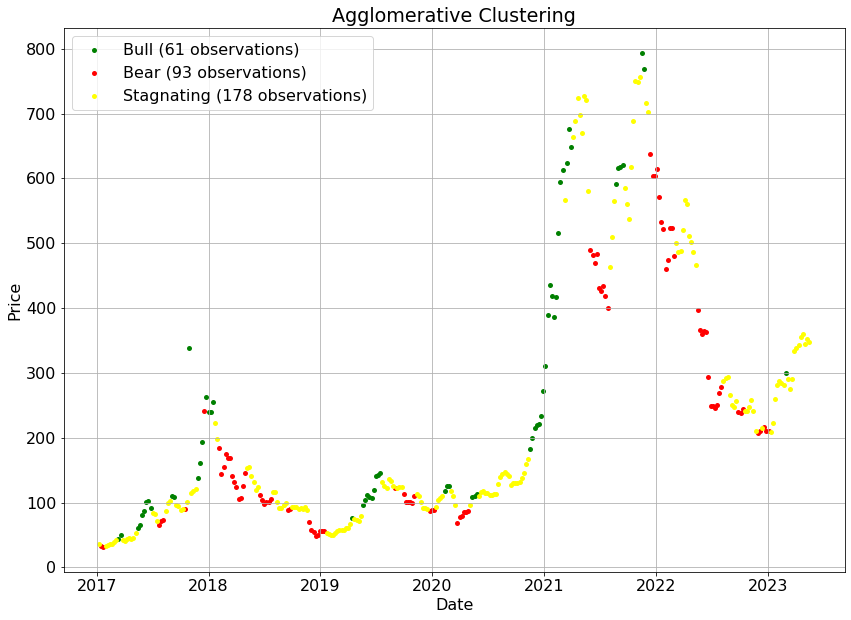

In [17]:
params = {'n_clusters': 3, 'affinity': 'manhattan', 'metric': 'manhattan'}

clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array)
# Assign the predicted hidden states to the DataFrame as the MarketRegime column
df_agglo = df_determination.copy()
df_agglo['MarketRegime'] = clustering_states
plot_hidden_states(np.array(clustering_states), df_agglo, title="Agglomerative Clustering", fname="AgglomerativeClustering3")

In [10]:
df_agglo[['target']] = df_agglo[['ReferenceRate']].pct_change().shift(-1)
df_agglo.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
0             0.025357  0.133427    61
1             0.002424  0.079628    93
2             0.017983  0.191780   177

### Detection of market regimes using K-means:

/home/lmilo_ext/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


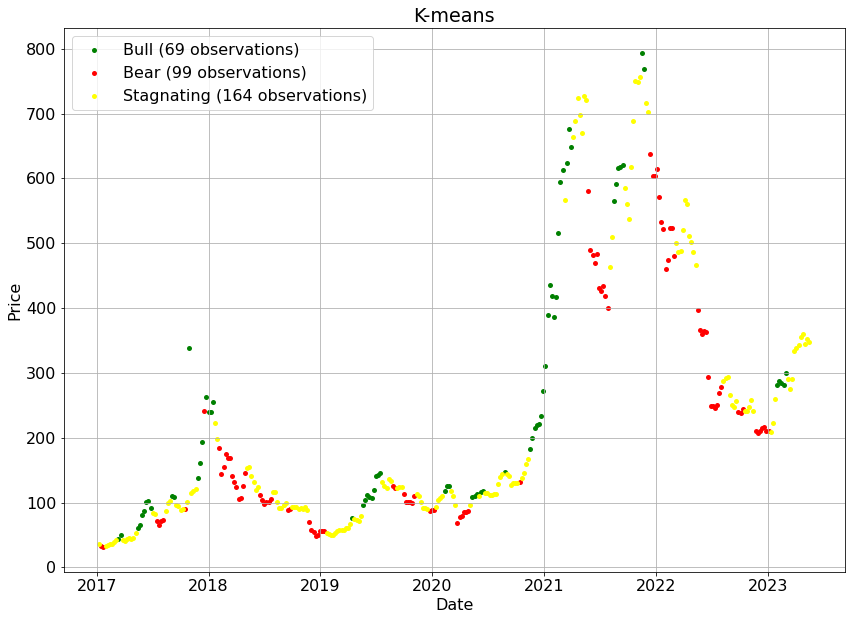

In [31]:
params = {'n_clusters': 3, 'n_init': 'auto', 'max_iter':1000, 'random_state':42}

kmeans = regime_detection.get_regimes_kmeans(params)
kmeans_states = kmeans.fit_predict(prices_array)
# Assign the predicted hidden states to the DataFrame as the MarketRegime column
df_kmeans = df_determination.copy()
df_kmeans['MarketRegime'] = kmeans_states
plot_hidden_states(np.array(kmeans_states), df_kmeans, title="K-means", fname="K-means3")
# The K-means algorithm can be sensitive to the initial placement of cluster centroids, and it might produce different results even when a random_state is set.
# Hence might need to execute several times before getting same color assignment to the regimes as for the other methods.

In [32]:
df_kmeans[['target']] = df_kmeans[['ReferenceRate']].pct_change().shift(-1)
df_kmeans.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
0             0.023519  0.125884    69
1            -0.000057  0.079571    99
2             0.020479  0.199027   163

### Detection of market regimes using GMM:

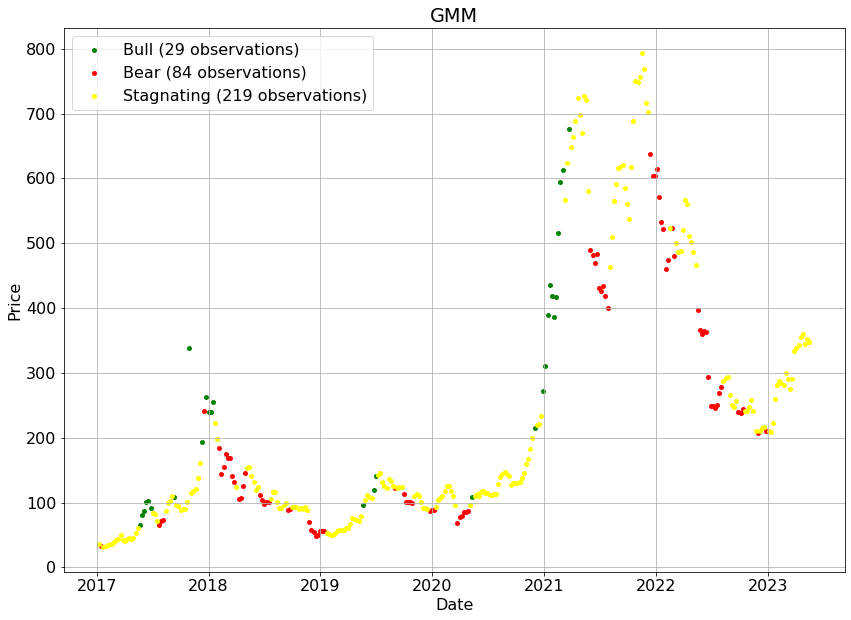

In [13]:
# Set the random seed
np.random.seed(33)
params = {'n_components':3, 'num_init':300, 'init_params': 'random'}
gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
# Assign the predicted hidden states to the DataFrame as the MarketRegime column
df_gmm = df_determination.copy()
df_gmm['MarketRegime'] = gmm_states
plot_hidden_states(np.array(gmm_states), df_gmm, title="GMM", fname="GMM3")

In [14]:
df_gmm[['target']] = df_gmm[['ReferenceRate']].pct_change().shift(-1)
df_gmm.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
0             0.023307  0.175836    29
1             0.000906  0.080180    84
2             0.019281  0.176049   218

### Detection of market regimes using HMM:

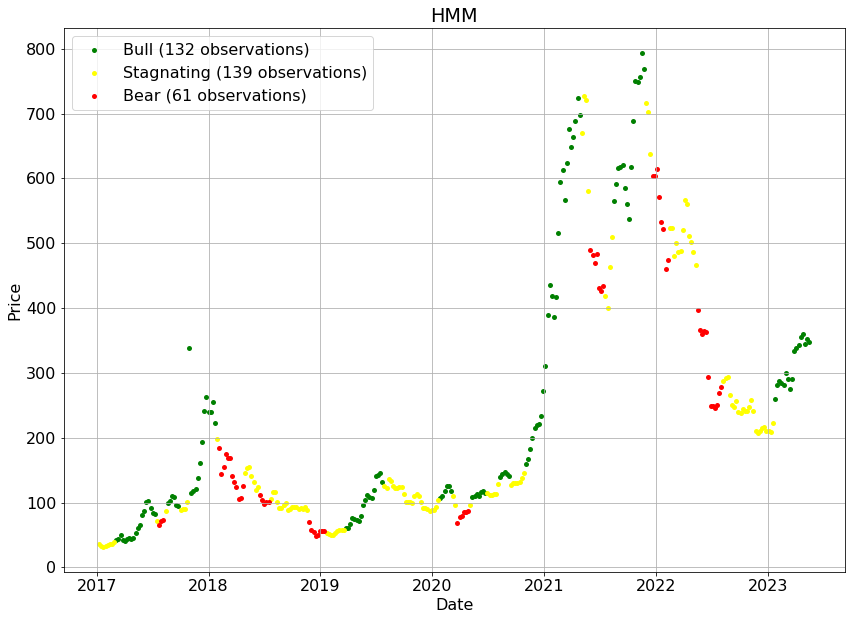

In [15]:
# Seed for reproducibility
np.random.seed(33)

# Define the number of random restarts
num_restarts = 200

# Initialize variables to store the best model and its log-likelihood
best_model = None
best_log_likelihood = -np.inf

# Initialize a new DataFrame to store the market regime labels
df_hmm = df_determination.copy()
df_hmm['MarketRegime'] = np.nan

# Perform multiple random restarts
for i in range(num_restarts):
    # Initialize the HMM with 3 states
    params = {'n_components': 3, 'covariance_type': 'full', 'random_state': i}

    # Create and fit the HMM
    hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
    hmm_model.fit(prices_array)

    # Calculate the log-likelihood of the trained model
    log_likelihood = hmm_model.score(prices_array)

    # Check if this model has a higher log-likelihood than the previous best model
    if log_likelihood > best_log_likelihood:
        best_model = hmm_model
        best_log_likelihood = log_likelihood

# Use the best model for determination
hmm_states = best_model.predict(prices_array)
# Assign the predicted hidden states to the DataFrame as the MarketRegime column
df_hmm['MarketRegime'] = hmm_states
# Plot the distribution
plot_hidden_states(np.array(hmm_states), df_hmm, title="HMM", fname="HMM3")

In [33]:
df_hmm[['target']] = df_hmm[['ReferenceRate']].pct_change().shift(-1)
df_hmm.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
0             0.026442  0.103329   131
1             0.013071  0.212791   139
2            -0.005335  0.088321    61

In [ ]:
# Print the modified DataFrame with MarketRegime column
df_hmm.drop(columns=['target'], inplace=True)
df_hmm.info()

In [ ]:
output_folder = '/home/lmilo_ext/Data/'
output_filename = 'labeled_data_3states.csv'

# Combine the folder path and filename
output_path = output_folder + output_filename
df_hmm['date'] = df_hmm.index
df_hmm.to_csv(output_path, index=False)